# Importando pacotes e baixando o dataset


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Star_galaxy_stripe82.csv')

In [4]:
data = df.copy()

In [5]:
data.head()

,specObjID,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,4.380402e+17,3.606484,-0.141486,GALAXY,0.063335,0.000016,19.18945,0.148011,18.11453,0.029842,17.48079,0.025818,17.16036,0.027270
1,4.380405e+17,3.637356,-0.175298,GALAXY,0.064647,0.000031,19.98902,0.167935,18.13386,0.021614,17.35864,0.016762,16.99493,0.019215
2,4.380408e+17,3.722365,-0.474311,QSO,1.924382,0.000308,19.56212,0.034653,19.59155,0.016240,19.42810,0.019360,18.91112,0.017962
3,4.380411e+17,3.654366,-0.262900,GALAXY,0.065348,0.000021,19.03313,0.105097,17.29383,0.011121,16.47390,0.008431,16.08835,0.008618
4,4.380413e+17,3.172661,-1.053429,GALAXY,0.069554,0.000008,19.48644,0.110411,18.19550,0.019056,17.68582,0.022735,17.37941,0.020684


# Tratando dos dados

In [6]:
data.drop(columns = ['specObjID', 'ra', 'dec', 'z', 'zErr'], axis = 1, inplace = True)

In [7]:
mapping = {'STAR': 0, 'GALAXY': 1, 'QSO': 2}

data = data.replace({'class': mapping})

In [8]:
data.head()

,class,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,1,19.18945,0.148011,18.11453,0.029842,17.48079,0.025818,17.16036,0.027270
1,1,19.98902,0.167935,18.13386,0.021614,17.35864,0.016762,16.99493,0.019215
2,2,19.56212,0.034653,19.59155,0.016240,19.42810,0.019360,18.91112,0.017962
3,1,19.03313,0.105097,17.29383,0.011121,16.47390,0.008431,16.08835,0.008618
4,1,19.48644,0.110411,18.19550,0.019056,17.68582,0.022735,17.37941,0.020684


Pegando apenas as linhas do dataset com linhas em que as magnitudes são maiores que 0.

In [9]:
data = data[data['petroMag_u'] > 0]
data = data[data['petroMagErr_u'] > 0]
data = data[data['petroMag_g'] > 0]
data = data[data['petroMagErr_g'] > 0]
data = data[data['petroMag_r'] > 0]
data = data[data['petroMagErr_r'] > 0]
data = data[data['petroMag_i'] > 0]
data = data[data['petroMagErr_i'] > 0]

Também escolho as linha em que as magnitudes são menores que 100, e que seus respectivos erros são menores que 10% da magnitude.

In [10]:
data = data[data['petroMag_u'] < 100]
data = data[data['petroMagErr_u'] < np.max(data['petroMag_u'])/10]
data = data[data['petroMag_g'] < 100]
data = data[data['petroMagErr_g'] < np.max(data['petroMag_g'])/10]
data = data[data['petroMag_r'] < 100]
data = data[data['petroMagErr_r'] < np.max(data['petroMag_r'])/10]
data = data[data['petroMag_i'] < 100]
data = data[data['petroMagErr_i'] < np.max(data['petroMag_i'])/10]

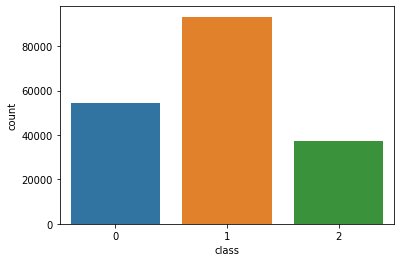

In [11]:
sns.countplot(x = 'class', data = data)

In [12]:
data['class'].value_counts()

1    93304
0    54231
2    37117
Name: class, dtype: int64

# Comparações entre undersampling, baseline e modelo com pesos.

Começando com o undersampling.

In [13]:
dataunder = data[:-30000]

In [14]:
valunder = data[-30000:]

In [15]:
x_datastar = dataunder[dataunder['class'] == 0]
x_datagalaxy = dataunder[dataunder['class'] == 1]
x_dataqso = dataunder[dataunder['class'] == 2]

In [16]:
x_dataunder = pd.concat([x_datastar, x_datagalaxy[:len(x_datastar)]])

In [17]:
x_dataunder = pd.concat([x_dataunder, x_dataqso[:len(x_datastar)]])

In [18]:
x_dataunder = x_dataunder.sample(frac = 1)

In [19]:
yunder = x_dataunder['class']

In [20]:
x_dataunder = x_dataunder.drop(['class'], axis =1)

In [21]:
xunder = (x_dataunder - np.min(x_dataunder))/(np.max(x_dataunder) - np.min(x_dataunder))

In [22]:
x_trainunder, x_testunder, y_trainunder, y_testunder = train_test_split(xunder, yunder, test_size = 0.2, random_state = 3) 

model = Sequential()

model.add(Dense(128, activation = 'relu', input_shape = (xunder.shape[1],)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  

In [23]:
historyt = model.fit(
    x_trainunder,
    to_categorical(y_trainunder),
    epochs = 20,
    batch_size = 128,
    validation_data = (
        x_testunder,
        to_categorical(y_testunder)
    )
)

Epoch 1/20
815/815 [==============================] - 2s 3ms/step - loss: 0.7861 - accuracy: 0.6414 - val_loss: 0.6196 - val_accuracy: 0.7537
Epoch 2/20
815/815 [==============================] - 2s 2ms/step - loss: 0.5107 - accuracy: 0.8216 - val_loss: 0.4522 - val_accuracy: 0.8267
Epoch 3/20
815/815 [==============================] - 2s 2ms/step - loss: 0.4285 - accuracy: 0.8455 - val_loss: 0.4051 - val_accuracy: 0.8523
Epoch 4/20
815/815 [==============================] - 2s 3ms/step - loss: 0.4009 - accuracy: 0.8540 - val_loss: 0.3858 - val_accuracy: 0.8610
Epoch 5/20
815/815 [==============================] - 2s 2ms/step - loss: 0.3847 - accuracy: 0.8596 - val_loss: 0.3717 - val_accuracy: 0.8639
Epoch 6/20
815/815 [==============================] - 2s 2ms/step - loss: 0.3733 - accuracy: 0.8639 - val_loss: 0.3666 - val_accuracy: 0.8668
Epoch 7/20
815/815 [==============================] - 2s 2ms/step - loss: 0.3642 - accuracy: 0.8672 - val_loss: 0.3577 - val_accuracy: 0.8704
Epoch 

In [24]:
yval = valunder['class']

In [25]:
x_valunder = valunder.drop(['class'], axis = 1)

In [26]:
xvalunder = (x_valunder - np.min(x_valunder))/(np.max(x_valunder) - np.min(x_valunder))

In [27]:
underpred = model.predict(xvalunder)

In [28]:
cmatrixunder = confusion_matrix(np.array(yval), np.argmax(underpred, axis = 1))
cmatrixunder

array([[  993,  1620,   920],
       [   74,  6691, 11517],
       [   49,   750,  7386]])

In [29]:
label = ['Star', 'Galaxy', 'Quasar']

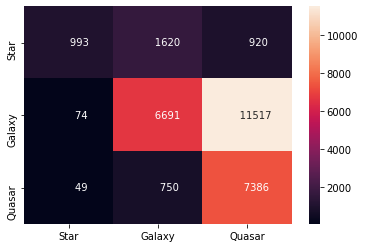

In [30]:
sns.heatmap(cmatrixunder, xticklabels = label, yticklabels = label, annot = True, fmt = '10')

In [31]:
yval.value_counts()

1    18282
2     8185
0     3533
Name: class, dtype: int64



---


Agora o modelo Baseline.


---


In [32]:
yt = data['class']

In [33]:
x_datat = data.drop(['class'], axis = 1)

In [34]:
xt = (x_datat - np.min(x_datat))/(np.max(x_datat) - np.min(x_datat))

In [35]:
x_traint, x_testt, y_traint, y_testt = train_test_split(xt, yt, test_size = 0.2, random_state = 3) 

model = Sequential()

model.add(Dense(128, activation = 'relu', input_shape = (xt.shape[1],)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [36]:
historyt = model.fit(
    x_traint,
    to_categorical(y_traint),
    epochs = 20,
    batch_size = 128,
    validation_data = (
        x_testt,
        to_categorical(y_testt)
    )
)

Epoch 1/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.7044 - accuracy: 0.7156 - val_loss: 0.5372 - val_accuracy: 0.8257
Epoch 2/20
1155/1155 [==============================] - 3s 2ms/step - loss: 0.4698 - accuracy: 0.8364 - val_loss: 0.4422 - val_accuracy: 0.8432
Epoch 3/20
1155/1155 [==============================] - 3s 2ms/step - loss: 0.4222 - accuracy: 0.8505 - val_loss: 0.4032 - val_accuracy: 0.8576
Epoch 4/20
1155/1155 [==============================] - 3s 2ms/step - loss: 0.4024 - accuracy: 0.8575 - val_loss: 0.3905 - val_accuracy: 0.8609
Epoch 5/20
1155/1155 [==============================] - 3s 2ms/step - loss: 0.3903 - accuracy: 0.8621 - val_loss: 0.3968 - val_accuracy: 0.8610
Epoch 6/20
1155/1155 [==============================] - 3s 2ms/step - loss: 0.3832 - accuracy: 0.8649 - val_loss: 0.3732 - val_accuracy: 0.8669
Epoch 7/20
1155/1155 [==============================] - 3s 2ms/step - loss: 0.3754 - accuracy: 0.8673 - val_loss: 0.3681 - val_accuracy:

In [37]:
test_predt = model.predict(x_testt)

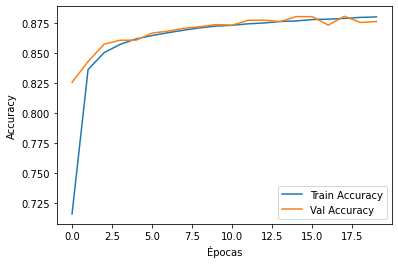

In [38]:
plt.plot(historyt.history['accuracy'], label = 'Train Accuracy')
plt.plot(historyt.history['val_accuracy'], label = 'Val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Épocas')
plt.legend()

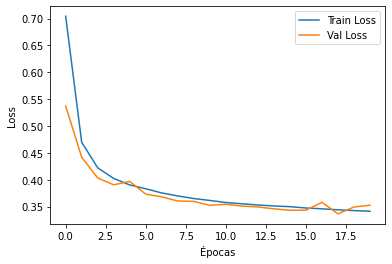

In [39]:
plt.plot(historyt.history['loss'], label = 'Train Loss')
plt.plot(historyt.history['val_loss'], label = 'Val Loss')
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.legend()

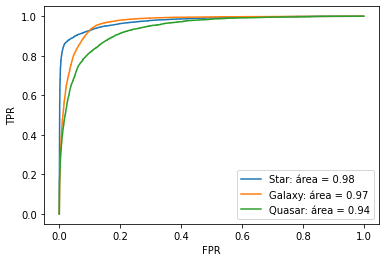

In [40]:
label = ['Star', 'Galaxy', 'Quasar']
for i in range(3):
  fprt, tprt, _ = roc_curve(to_categorical(np.array(y_testt))[:,i], test_predt[:,i])
  plt.plot(fprt, tprt, label = '{}: área = {:.2f}'.format(label[i],auc(fprt, tprt)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

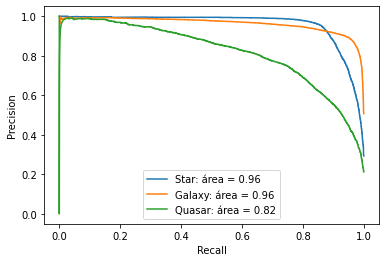

In [41]:
for i in range(3):
  precisiont, recallt, _ = precision_recall_curve(to_categorical(np.array(y_testt))[:, i],test_predt[:, i])
  plt.plot(recallt, precisiont, label = '{}: área = {:.2f}'.format(label[i],auc(recallt, precisiont)))

plt.xlabel(r'Recall')
plt.ylabel(r'Precision')
plt.legend()

In [42]:
cmatrixt = confusion_matrix(np.array(y_testt), np.argmax(test_predt, axis = 1))
cmatrixt

array([[ 8951,   712,  1146],
       [   86, 18010,   635],
       [  186,  1792,  5413]])

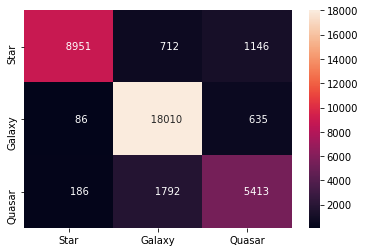

In [43]:
sns.heatmap(cmatrixt, xticklabels = label, yticklabels = label, annot = True, fmt = '10')

In [44]:
y_testt.value_counts()

1    18731
0    10809
2     7391
Name: class, dtype: int64

In [45]:
reportt = classification_report(y_testt, np.argmax(test_predt, axis = 1), target_names = ['Star', 'Galaxy', 'QSO'], output_dict = True)
reportt = pd.DataFrame(reportt)
reportt.drop(index = ['support'], columns = ['accuracy', 'macro avg', 'weighted avg'], inplace = True)
reportt

,Star,Galaxy,QSO
precision,0.970509,0.877937,0.752433
recall,0.828106,0.961508,0.732377
f1-score,0.893670,0.917824,0.742269




---


E finalmente o modelo com pesos.


---

In [46]:
yt2 = data['class']

In [47]:
x_datat2 = data.drop(['class'], axis = 1)

In [48]:
xt2 = (x_datat2 - np.min(x_datat2))/(np.max(x_datat2) - np.min(x_datat2))

In [49]:
x_traint2, x_testt2, y_traint2, y_testt2 = train_test_split(xt2, yt2, test_size = 0.2, random_state = 3) 

class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(y_traint2),
    y_traint2
)
class_weights = {i  :class_weights[i] for i in range(3)}

model = Sequential()

model.add(Dense(128, activation = 'relu', input_shape = (xt2.shape[1],)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [50]:
historyt2 = model.fit(
    x_traint2,
    to_categorical(y_traint2),
    epochs = 20,
    batch_size = 128,
    validation_data = (x_testt2, to_categorical(y_testt2)),
    class_weight = class_weights
)

Epoch 1/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.7249 - accuracy: 0.6561 - val_loss: 0.6573 - val_accuracy: 0.7250
Epoch 2/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.5383 - accuracy: 0.8052 - val_loss: 0.4676 - val_accuracy: 0.8353
Epoch 3/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4861 - accuracy: 0.8306 - val_loss: 0.4434 - val_accuracy: 0.8400
Epoch 4/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4635 - accuracy: 0.8401 - val_loss: 0.4527 - val_accuracy: 0.8362
Epoch 5/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4462 - accuracy: 0.8467 - val_loss: 0.4355 - val_accuracy: 0.8383
Epoch 6/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4309 - accuracy: 0.8518 - val_loss: 0.4117 - val_accuracy: 0.8506
Epoch 7/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4210 - accuracy: 0.8544 - val_loss: 0.3878 - val_accuracy:

In [51]:
test_predt2 = model.predict(x_testt2)

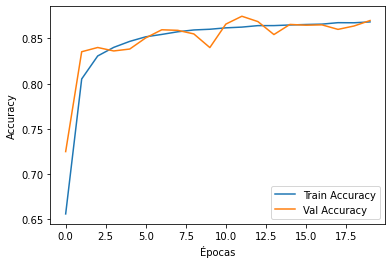

In [52]:
plt.plot(historyt2.history['accuracy'], label = 'Train Accuracy')
plt.plot(historyt2.history['val_accuracy'], label = 'Val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Épocas')
plt.legend()

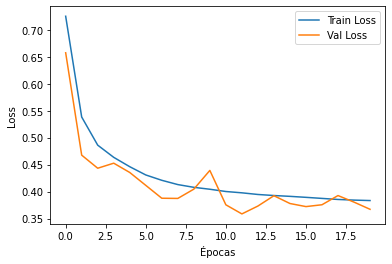

In [53]:
plt.plot(historyt2.history['loss'], label = 'Train Loss')
plt.plot(historyt2.history['val_loss'], label = 'Val Loss')
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.legend()

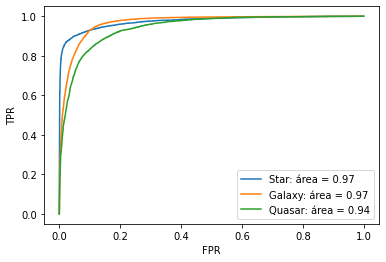

In [54]:
label = ['Star', 'Galaxy', 'Quasar']
for i in range(3):
  fprt2, tprt2, _ = roc_curve(to_categorical(np.array(y_testt2))[:,i], test_predt2[:,i])
  plt.plot(fprt2, tprt2, label = '{}: área = {:.2f}'.format(label[i],auc(fprt2, tprt2)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

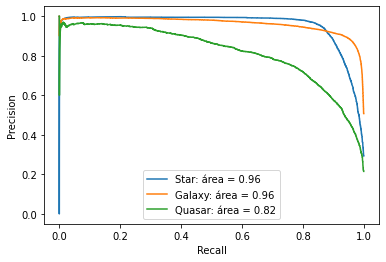

In [55]:
for i in range(3):
  precisiont2, recallt2, _ = precision_recall_curve(to_categorical(np.array(y_testt2))[:, i],test_predt2[:, i])
  plt.plot(recallt2, precisiont2, label = '{}: área = {:.2f}'.format(label[i],auc(recallt2, precisiont2)))

plt.xlabel(r'Recall')
plt.ylabel(r'Precision')
plt.legend()

In [56]:
cmatrixt2 = confusion_matrix(np.array(y_testt2), np.argmax(test_predt2, axis = 1))
cmatrixt2

array([[ 9349,   466,   994],
       [  250, 16677,  1804],
       [  298,   998,  6095]])

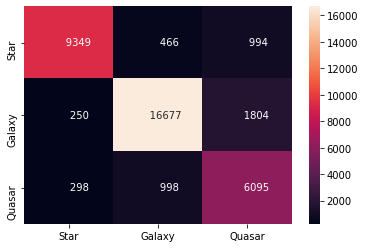

In [57]:
sns.heatmap(cmatrixt2, xticklabels = label, yticklabels = label, annot = True, fmt = '10')

In [58]:
y_testt2.value_counts()

1    18731
0    10809
2     7391
Name: class, dtype: int64

In [59]:
reportt2 = classification_report(y_testt2, np.argmax(test_predt2, axis = 1), target_names = ['Star', 'Galaxy', 'QSO'], output_dict = True)
reportt2 = pd.DataFrame(reportt2)
reportt2.drop(index = ['support'], columns = ['accuracy', 'macro avg', 'weighted avg'], inplace = True)
reportt2

,Star,Galaxy,QSO
precision,0.944630,0.919299,0.685371
recall,0.864927,0.890342,0.824652
f1-score,0.903023,0.904589,0.748588




---
# Cross validation

Decidi fazer cross validation apenas para o modelo baseline e o modelo com pesos.


Vamos começar com a rede menos profunda.

In [ ]:
y = data['class']

In [ ]:
x_data = data.drop(['class'], axis = 1)

In [ ]:
x = (x_data - np.min(x_data))/(np.max(x_data) - np.min(x_data))

In [ ]:
folds = 10
n_classes = 3

train_acc = []
train_loss = []

val_acc = []
val_loss = []

# For each class
precision = [{}]*folds
recall = [{}]*folds
average_precision = [{}]*folds

fpr = [{}]*folds
tpr = [{}]*folds
roc_auc = [{}]*folds

train_accw = []
train_lossw = []

val_accw = []
val_lossw = []

# For each class
precisionw = [{}]*folds
recallw = [{}]*folds
average_precisionw = [{}]*folds

fprw = [{}]*folds
tprw = [{}]*folds
roc_aucw = [{}]*folds


for i in range(folds):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = i) 

  model = Sequential()

  model.add(Dense(128, activation = 'relu', input_shape = (x.shape[1],)))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(3, activation = 'softmax'))

  model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  

  history = model.fit(
    x_train,
    to_categorical(y_train),
    epochs = 20,
    batch_size = 128,
    validation_data = (
        x_test,
        to_categorical(y_test)
    )
)
  
  test_pred = model.predict(x_test)
  
  train_acc.append(history.history['accuracy'])
  train_loss.append(history.history['loss'])

  val_acc.append(history.history['val_accuracy'])
  val_loss.append(history.history['val_loss'])

#------------------------------------------------------------------------------#

  x_trainw, x_testw, y_trainw, y_testw = train_test_split(x, y, test_size = 0.2, random_state = i) 

  class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(y_trainw),
    y_trainw
  )
  class_weights = {i  :class_weights[i] for i in range(3)}

  modelw = Sequential()

  modelw.add(Dense(128, activation = 'relu', input_shape = (x.shape[1],)))
  modelw.add(Dense(32, activation = 'relu'))
  modelw.add(Dense(3, activation = 'softmax'))

  modelw.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  

  historyw = modelw.fit(
    x_trainw,
    to_categorical(y_trainw),
    epochs = 20,
    batch_size = 128,
    validation_data = (
        x_testw,
        to_categorical(y_testw)),
        class_weight = class_weights

)
  
  test_predw = modelw.predict(x_testw)
  
  train_accw.append(historyw.history['accuracy'])
  train_lossw.append(historyw.history['loss'])

  val_accw.append(historyw.history['val_accuracy'])
  val_lossw.append(historyw.history['val_loss'])

  for j in range(n_classes):
      precision[i][j], recall[i][j], _ = precision_recall_curve(to_categorical(np.array(y_test))[:, j],test_pred[:, j])
      precisionw[i][j], recallw[i][j], _ = precision_recall_curve(to_categorical(np.array(y_testw))[:, j],test_predw[:, j])

  for j in range(n_classes):
    fpr[i][j], tpr[i][j], _ = roc_curve(to_categorical(np.array(y_test))[:,j], test_pred[:,j])
    fprw[i][j], tprw[i][j], _ = roc_curve(to_categorical(np.array(y_testw))[:,j], test_predw[:,j])

Epoch 1/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.7098 - accuracy: 0.7081 - val_loss: 0.5493 - val_accuracy: 0.7926
Epoch 2/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4800 - accuracy: 0.8344 - val_loss: 0.4448 - val_accuracy: 0.8436
Epoch 3/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4296 - accuracy: 0.8472 - val_loss: 0.4325 - val_accuracy: 0.8458
Epoch 4/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4049 - accuracy: 0.8541 - val_loss: 0.3973 - val_accuracy: 0.8563
Epoch 5/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.3884 - accuracy: 0.8606 - val_loss: 0.3868 - val_accuracy: 0.8576
Epoch 6/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.3776 - accuracy: 0.8643 - val_loss: 0.3734 - val_accuracy: 0.8655
Epoch 7/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.3703 - accuracy: 0.8675 - val_loss: 0.3697 - val_accuracy:

In [ ]:
epochs = np.linspace(0,19,20)

train_acc_mean = np.average(np.vstack(train_acc), axis = 0)
train_loss_mean = np.average(np.vstack(train_loss), axis = 0)
train_acc_std = np.std(np.vstack(train_acc), axis = 0)
train_loss_std = np.std(np.vstack(train_loss), axis = 0)

val_acc_mean = np.average(np.vstack(val_acc), axis = 0)
val_loss_mean = np.average(np.vstack(val_loss), axis = 0)
val_acc_std = np.std(np.vstack(val_acc), axis = 0)
val_loss_std = np.std(np.vstack(val_loss), axis = 0)

#--------------------------------------------------------------#

train_acc_meanw = np.average(np.vstack(train_accw), axis = 0)
train_loss_meanw = np.average(np.vstack(train_lossw), axis = 0)
train_acc_stdw = np.std(np.vstack(train_accw), axis = 0)
train_loss_stdw = np.std(np.vstack(train_lossw), axis = 0)

val_acc_meanw = np.average(np.vstack(val_accw), axis = 0)
val_loss_meanw = np.average(np.vstack(val_lossw), axis = 0)
val_acc_stdw = np.std(np.vstack(val_accw), axis = 0)
val_loss_stdw = np.std(np.vstack(val_lossw), axis = 0)

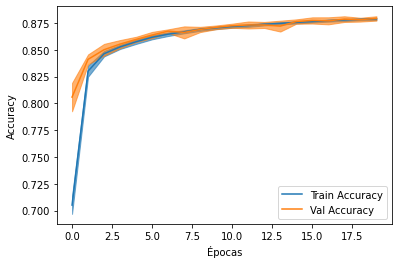

In [ ]:
plt.plot(train_acc_mean, label = r'Train Accuracy', color = 'C0')
plt.fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color = 'C0', alpha = 0.6)
plt.plot(val_acc_mean, label = r'Val Accuracy', color = 'C1')
plt.fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Accuracy')
plt.legend()

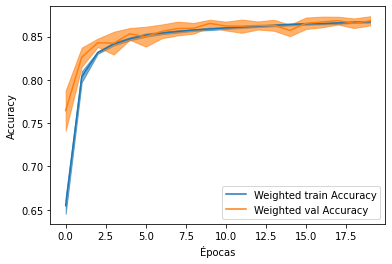

In [ ]:
plt.plot(train_acc_meanw, label = r'Weighted train Accuracy', color = 'C0')
plt.fill_between(epochs, train_acc_meanw - train_acc_stdw, train_acc_meanw + train_acc_stdw, color = 'C0', alpha = 0.6)
plt.plot(val_acc_meanw, label = r'Weighted val Accuracy', color = 'C1')
plt.fill_between(epochs, val_acc_meanw - val_acc_stdw, val_acc_meanw + val_acc_stdw, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Accuracy')
plt.legend()

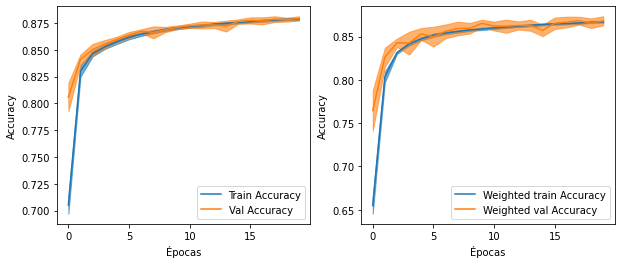

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(train_acc_mean, label = r'Train Accuracy', color = 'C0')
ax1.fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color = 'C0', alpha = 0.6)
ax1.plot(val_acc_mean, label = r'Val Accuracy', color = 'C1')
ax1.fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color = 'C1', alpha = 0.6)
ax1.set_xlabel(r'Épocas')
ax1.set_ylabel(r'Accuracy')
ax1.legend()

#plt.subplot(1,2,2)
ax2.plot(train_acc_meanw, label = r'Weighted train Accuracy', color = 'C0')
ax2.fill_between(epochs, train_acc_meanw - train_acc_stdw, train_acc_meanw + train_acc_stdw, color = 'C0', alpha = 0.6)
ax2.plot(val_acc_meanw, label = r'Weighted val Accuracy', color = 'C1')
ax2.fill_between(epochs, val_acc_meanw - val_acc_stdw, val_acc_meanw + val_acc_stdw, color = 'C1', alpha = 0.6)
ax2.set_xlabel(r'Épocas')
ax2.set_ylabel(r'Accuracy')
ax2.legend()

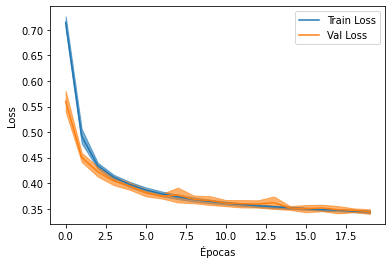

In [ ]:
plt.plot(train_loss_mean, label = r'Train Loss', color = 'C0')
plt.fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color = 'C0', alpha = 0.6)
plt.plot(val_loss_mean, label = r'Val Loss', color = 'C1')
plt.fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Loss')
plt.legend()

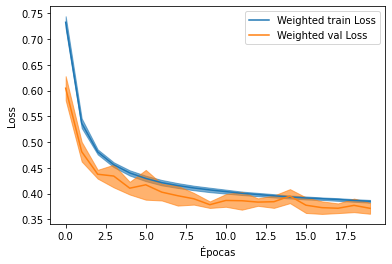

In [ ]:
plt.plot(train_loss_meanw, label = r'Weighted train Loss', color = 'C0')
plt.fill_between(epochs, train_loss_meanw - train_loss_stdw, train_loss_meanw + train_loss_stdw, color = 'C0', alpha = 0.6)
plt.plot(val_loss_meanw, label = r'Weighted val Loss', color = 'C1')
plt.fill_between(epochs, val_loss_meanw - val_loss_stdw, val_loss_meanw + val_loss_stdw, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Loss')
plt.legend()

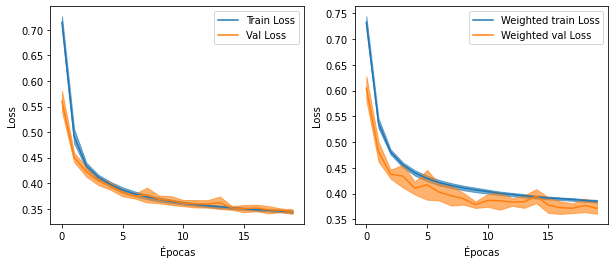

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(train_loss_mean, label = r'Train Loss', color = 'C0')
ax1.fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color = 'C0', alpha = 0.6)
ax1.plot(val_loss_mean, label = r'Val Loss', color = 'C1')
ax1.fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color = 'C1', alpha = 0.6)
ax1.set_xlabel(r'Épocas')
ax1.set_ylabel(r'Loss')
ax1.legend()

#--------------------------------------------------------------#

ax2.plot(train_loss_meanw, label = r'Weighted train Loss', color = 'C0')
ax2.fill_between(epochs, train_loss_meanw - train_loss_stdw, train_loss_meanw + train_loss_stdw, color = 'C0', alpha = 0.6)
ax2.plot(val_loss_meanw, label = r'Weighted val Loss', color = 'C1')
ax2.fill_between(epochs, val_loss_meanw - val_loss_stdw, val_loss_meanw + val_loss_stdw, color = 'C1', alpha = 0.6)
ax2.set_xlabel(r'Épocas')
ax2.set_ylabel(r'Loss')
ax2.legend()

In [ ]:
precisions = []
precisiong = []
precisionq = []

recalls = []
recallg = []
recallq = []

for i in range(10):
  precisions.append(np.array(precision)[i][0])
  precisiong.append(np.array(precision)[i][1])
  precisionq.append(np.array(precision)[i][2])
  recalls.append(np.array(recall)[i][0])
  recallg.append(np.array(recall)[i][1])
  recallq.append(np.array(recall)[i][2])

#--------------------------------------------------------------#

precisionsw = []
precisiongw = []
precisionqw = []

recallsw = []
recallgw = []
recallqw = []

for i in range(10):
  precisionsw.append(np.array(precisionw)[i][0])
  precisiongw.append(np.array(precisionw)[i][1])
  precisionqw.append(np.array(precisionw)[i][2])
  recallsw.append(np.array(recallw)[i][0])
  recallgw.append(np.array(recallw)[i][1])
  recallqw.append(np.array(recallw)[i][2])

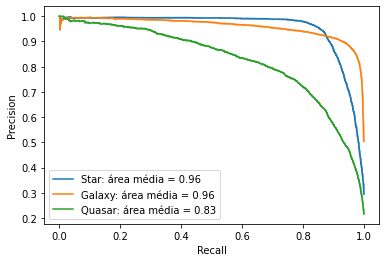

In [ ]:
plt.plot(np.average(np.vstack(recalls), axis = 0),np.average(np.vstack(precisions), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recalls), axis = 0), np.average(np.vstack(precisions), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(recallg), axis = 0),np.average(np.vstack(precisiong), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallg), axis = 0), np.average(np.vstack(precisiong), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(recallq), axis = 0),np.average(np.vstack(precisionq), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallq), axis = 0), np.average(np.vstack(precisionq), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(recalls), axis = 0), np.std(np.vstack(precisions), axis = 0) + np.average(np.vstack(precisions), axis = 0), - np.std(np.vstack(precisions), axis = 0) + np.average(np.vstack(precisions), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallg), axis = 0), np.std(np.vstack(precisiong), axis = 0) + np.average(np.vstack(precisiong), axis = 0), - np.std(np.vstack(precisiong), axis = 0) + np.average(np.vstack(precisiong), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallq), axis = 0), np.std(np.vstack(precisionq), axis = 0) + np.average(np.vstack(precisionq), axis = 0), - np.std(np.vstack(precisionq), axis = 0) + np.average(np.vstack(precisionq), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'Recall')
plt.ylabel(r'Precision')
plt.legend()

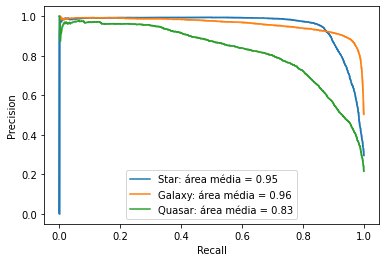

In [ ]:
plt.plot(np.average(np.vstack(recallsw), axis = 0),np.average(np.vstack(precisionsw), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recallsw), axis = 0), np.average(np.vstack(precisionsw), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(recallgw), axis = 0),np.average(np.vstack(precisiongw), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallgw), axis = 0), np.average(np.vstack(precisiongw), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(recallqw), axis = 0),np.average(np.vstack(precisionqw), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallqw), axis = 0), np.average(np.vstack(precisionqw), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(recallsw), axis = 0), np.std(np.vstack(precisionsw), axis = 0) + np.average(np.vstack(precisionsw), axis = 0), - np.std(np.vstack(precisionsw), axis = 0) + np.average(np.vstack(precisionsw), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallgw), axis = 0), np.std(np.vstack(precisiongw), axis = 0) + np.average(np.vstack(precisiongw), axis = 0), - np.std(np.vstack(precisiongw), axis = 0) + np.average(np.vstack(precisiongw), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallqw), axis = 0), np.std(np.vstack(precisionqw), axis = 0) + np.average(np.vstack(precisionqw), axis = 0), - np.std(np.vstack(precisionqw), axis = 0) + np.average(np.vstack(precisionqw), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'Recall')
plt.ylabel(r'Precision')
plt.legend()

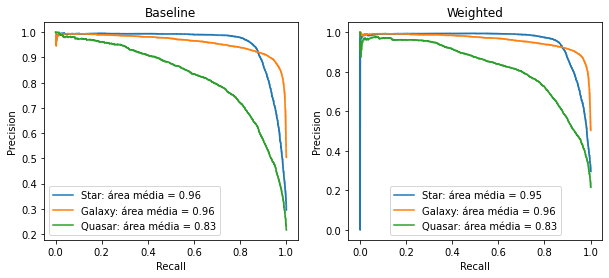

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(np.average(np.vstack(recalls), axis = 0),np.average(np.vstack(precisions), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recalls), axis = 0), np.average(np.vstack(precisions), axis = 0)), color = 'C0')
ax1.plot(np.average(np.vstack(recallg), axis = 0),np.average(np.vstack(precisiong), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallg), axis = 0), np.average(np.vstack(precisiong), axis = 0)), color = 'C1')
ax1.plot(np.average(np.vstack(recallq), axis = 0),np.average(np.vstack(precisionq), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallq), axis = 0), np.average(np.vstack(precisionq), axis = 0)), color = 'C2')
ax1.fill_between(np.average(np.vstack(recalls), axis = 0), np.std(np.vstack(precisions), axis = 0) + np.average(np.vstack(precisions), axis = 0), - np.std(np.vstack(precisions), axis = 0) + np.average(np.vstack(precisions), axis = 0), color = 'C0', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(recallg), axis = 0), np.std(np.vstack(precisiong), axis = 0) + np.average(np.vstack(precisiong), axis = 0), - np.std(np.vstack(precisiong), axis = 0) + np.average(np.vstack(precisiong), axis = 0), color = 'C1', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(recallq), axis = 0), np.std(np.vstack(precisionq), axis = 0) + np.average(np.vstack(precisionq), axis = 0), - np.std(np.vstack(precisionq), axis = 0) + np.average(np.vstack(precisionq), axis = 0), color = 'C2', alpha = 0.5)

ax1.set_xlabel(r'Recall')
ax1.set_ylabel(r'Precision')
ax1.set_title(r'Baseline')
ax1.legend()

ax2.plot(np.average(np.vstack(recallsw), axis = 0),np.average(np.vstack(precisionsw), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recallsw), axis = 0), np.average(np.vstack(precisionsw), axis = 0)), color = 'C0')
ax2.plot(np.average(np.vstack(recallgw), axis = 0),np.average(np.vstack(precisiongw), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallgw), axis = 0), np.average(np.vstack(precisiongw), axis = 0)), color = 'C1')
ax2.plot(np.average(np.vstack(recallqw), axis = 0),np.average(np.vstack(precisionqw), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallqw), axis = 0), np.average(np.vstack(precisionqw), axis = 0)), color = 'C2')
ax2.fill_between(np.average(np.vstack(recallsw), axis = 0), np.std(np.vstack(precisionsw), axis = 0) + np.average(np.vstack(precisionsw), axis = 0), - np.std(np.vstack(precisionsw), axis = 0) + np.average(np.vstack(precisionsw), axis = 0), color = 'C0', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(recallgw), axis = 0), np.std(np.vstack(precisiongw), axis = 0) + np.average(np.vstack(precisiongw), axis = 0), - np.std(np.vstack(precisiongw), axis = 0) + np.average(np.vstack(precisiongw), axis = 0), color = 'C1', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(recallqw), axis = 0), np.std(np.vstack(precisionqw), axis = 0) + np.average(np.vstack(precisionqw), axis = 0), - np.std(np.vstack(precisionqw), axis = 0) + np.average(np.vstack(precisionqw), axis = 0), color = 'C2', alpha = 0.5)

ax2.set_xlabel(r'Recall')
ax2.set_ylabel(r'Precision')
ax2.set_title(r'Weighted')
ax2.legend()

In [ ]:
tprs = []
tprg = []
tprq = []

fprs = []
fprg = []
fprq = []

for i in range(10):
  tprs.append(np.array(tpr)[i][0])
  tprg.append(np.array(tpr)[i][1])
  tprq.append(np.array(tpr)[i][2])
  fprs.append(np.array(fpr)[i][0])
  fprg.append(np.array(fpr)[i][1])
  fprq.append(np.array(fpr)[i][2])

#-----------------------------------------------------------#

tprsw = []
tprgw = []
tprqw = []

fprsw = []
fprgw = []
fprqw = []

for i in range(10):
  tprsw.append(np.array(tprw)[i][0])
  tprgw.append(np.array(tprw)[i][1])
  tprqw.append(np.array(tprw)[i][2])
  fprsw.append(np.array(fprw)[i][0])
  fprgw.append(np.array(fprw)[i][1])
  fprqw.append(np.array(fprw)[i][2])

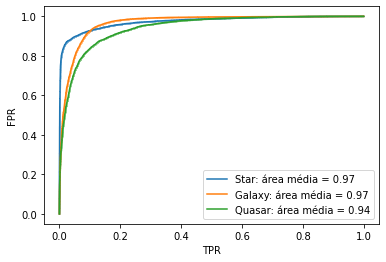

In [ ]:
plt.plot(np.average(np.vstack(fprs), axis = 0),np.average(np.vstack(tprs), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprs), axis = 0), np.average(np.vstack(tprs), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(fprg), axis = 0),np.average(np.vstack(tprg), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprg), axis = 0), np.average(np.vstack(tprg), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(fprq), axis = 0),np.average(np.vstack(tprq), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprq), axis = 0), np.average(np.vstack(tprq), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(fprs), axis = 0), np.std(np.vstack(tprs), axis = 0) + np.average(np.vstack(tprs), axis = 0), - np.std(np.vstack(tprs), axis = 0) + np.average(np.vstack(tprs), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprg), axis = 0), np.std(np.vstack(tprg), axis = 0) + np.average(np.vstack(tprg), axis = 0), - np.std(np.vstack(tprg), axis = 0) + np.average(np.vstack(tprg), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprq), axis = 0), np.std(np.vstack(tprq), axis = 0) + np.average(np.vstack(tprq), axis = 0), - np.std(np.vstack(tprq), axis = 0) + np.average(np.vstack(tprq), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'TPR')
plt.ylabel(r'FPR')
plt.legend()

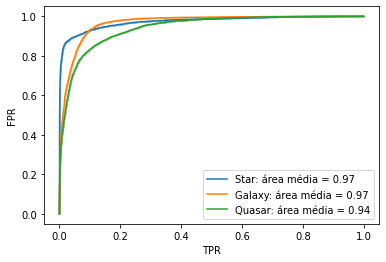

In [ ]:
plt.plot(np.average(np.vstack(fprsw), axis = 0),np.average(np.vstack(tprsw), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprsw), axis = 0), np.average(np.vstack(tprsw), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(fprgw), axis = 0),np.average(np.vstack(tprgw), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprgw), axis = 0), np.average(np.vstack(tprgw), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(fprqw), axis = 0),np.average(np.vstack(tprqw), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprqw), axis = 0), np.average(np.vstack(tprqw), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(fprsw), axis = 0), np.std(np.vstack(tprsw), axis = 0) + np.average(np.vstack(tprsw), axis = 0), - np.std(np.vstack(tprsw), axis = 0) + np.average(np.vstack(tprsw), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprgw), axis = 0), np.std(np.vstack(tprgw), axis = 0) + np.average(np.vstack(tprgw), axis = 0), - np.std(np.vstack(tprgw), axis = 0) + np.average(np.vstack(tprgw), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprqw), axis = 0), np.std(np.vstack(tprqw), axis = 0) + np.average(np.vstack(tprqw), axis = 0), - np.std(np.vstack(tprqw), axis = 0) + np.average(np.vstack(tprqw), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'TPR')
plt.ylabel(r'FPR')
plt.legend()

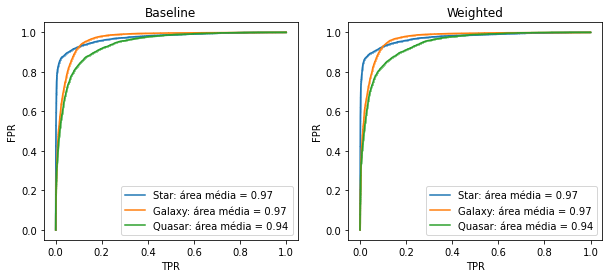

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(np.average(np.vstack(fprs), axis = 0),np.average(np.vstack(tprs), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprs), axis = 0), np.average(np.vstack(tprs), axis = 0)), color = 'C0')
ax1.plot(np.average(np.vstack(fprg), axis = 0),np.average(np.vstack(tprg), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprg), axis = 0), np.average(np.vstack(tprg), axis = 0)), color = 'C1')
ax1.plot(np.average(np.vstack(fprq), axis = 0),np.average(np.vstack(tprq), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprq), axis = 0), np.average(np.vstack(tprq), axis = 0)), color = 'C2')
ax1.fill_between(np.average(np.vstack(fprs), axis = 0), np.std(np.vstack(tprs), axis = 0) + np.average(np.vstack(tprs), axis = 0), - np.std(np.vstack(tprs), axis = 0) + np.average(np.vstack(tprs), axis = 0), color = 'C0', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(fprg), axis = 0), np.std(np.vstack(tprg), axis = 0) + np.average(np.vstack(tprg), axis = 0), - np.std(np.vstack(tprg), axis = 0) + np.average(np.vstack(tprg), axis = 0), color = 'C1', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(fprq), axis = 0), np.std(np.vstack(tprq), axis = 0) + np.average(np.vstack(tprq), axis = 0), - np.std(np.vstack(tprq), axis = 0) + np.average(np.vstack(tprq), axis = 0), color = 'C2', alpha = 0.5)

ax1.set_xlabel(r'TPR')
ax1.set_ylabel(r'FPR')
ax1.set_title(r'Baseline')
ax1.legend()

ax2.plot(np.average(np.vstack(fprsw), axis = 0),np.average(np.vstack(tprsw), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprsw), axis = 0), np.average(np.vstack(tprsw), axis = 0)), color = 'C0')
ax2.plot(np.average(np.vstack(fprgw), axis = 0),np.average(np.vstack(tprgw), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprgw), axis = 0), np.average(np.vstack(tprgw), axis = 0)), color = 'C1')
ax2.plot(np.average(np.vstack(fprqw), axis = 0),np.average(np.vstack(tprqw), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprqw), axis = 0), np.average(np.vstack(tprqw), axis = 0)), color = 'C2')
ax2.fill_between(np.average(np.vstack(fprsw), axis = 0), np.std(np.vstack(tprsw), axis = 0) + np.average(np.vstack(tprsw), axis = 0), - np.std(np.vstack(tprsw), axis = 0) + np.average(np.vstack(tprsw), axis = 0), color = 'C0', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(fprgw), axis = 0), np.std(np.vstack(tprgw), axis = 0) + np.average(np.vstack(tprgw), axis = 0), - np.std(np.vstack(tprgw), axis = 0) + np.average(np.vstack(tprgw), axis = 0), color = 'C1', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(fprqw), axis = 0), np.std(np.vstack(tprqw), axis = 0) + np.average(np.vstack(tprqw), axis = 0), - np.std(np.vstack(tprqw), axis = 0) + np.average(np.vstack(tprqw), axis = 0), color = 'C2', alpha = 0.5)

ax2.set_xlabel(r'TPR')
ax2.set_ylabel(r'FPR')
ax2.set_title(r'Weighted')
ax2.legend()

In [ ]:
labels = ['Star', 'Galaxy', 'Quasar']

In [ ]:
cmatrix = confusion_matrix(np.array(y_test), np.argmax(test_pred, axis = 1))
cmatrix

array([[ 9517,   607,   743],
       [  271, 17768,   586],
       [  472,  1830,  5137]])

In [ ]:
cmatrixw = confusion_matrix(np.array(y_testw), np.argmax(test_predw, axis = 1))
cmatrixw

array([[ 9458,   509,   900],
       [  254, 17052,  1319],
       [  373,  1174,  5892]])

In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 13.1MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463901 sha256=9d5d5e702b8275cc836eefb526a27de07fcb46990a035a7dbfff40a00e31b099
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
import shap
e = shap.DeepExplainer(model, np.array(x_train)[:5000,:])

keras is no longer supported, please use tf.keras instead.


In [ ]:
ew = shap.DeepExplainer(modelw, np.array(x_trainw)[:5000,:])

In [ ]:
shap_values = e.shap_values(np.array(x_train)[:2500,:])

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap_valuesw = e.shap_values(np.array(x_trainw)[:2500,:])



---
Importancia das features para o modelo baseline


---

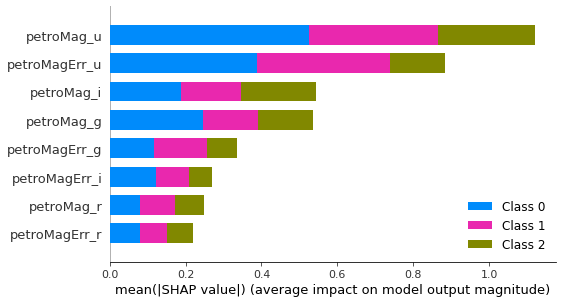

In [ ]:
shap.summary_plot(shap_values, np.array(x_test)[:1000,:], feature_names = x_test.columns)



---
Importancia das features para o modelo com pesos


---


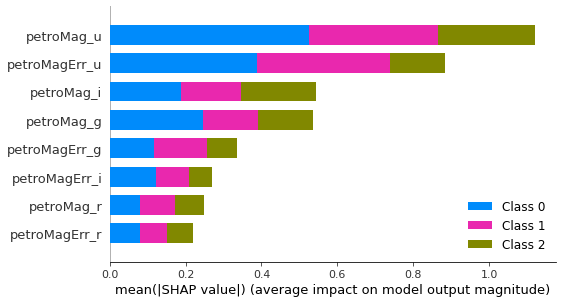

In [ ]:
shap.summary_plot(shap_valuesw, np.array(x_testw)[:1000,:], feature_names = x_test.columns)

Text(0.5, 1.0, 'Weighted')

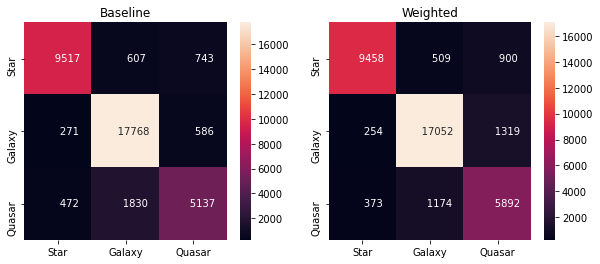

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

sns.heatmap(cmatrix, xticklabels = labels, yticklabels = labels, annot = True, fmt = '10', ax = ax1)
ax1.set_title(r'Baseline')
sns.heatmap(cmatrixw, xticklabels = labels, yticklabels = labels, annot = True, fmt = '10', ax = ax2)
ax2.set_title(r'Weighted')

In [ ]:
y_test.value_counts()

In [ ]:
report = classification_report(y_test, np.argmax(test_pred, axis = 1), target_names = ['Star', 'Galaxy', 'QSO'], output_dict = True)
report = pd.DataFrame(report)
report.drop(index = ['support'], columns = ['accuracy', 'macro avg', 'weighted avg'], inplace = True)
report

,Star,Galaxy,QSO
precision,0.927583,0.879386,0.794463
recall,0.875771,0.953987,0.690550
f1-score,0.900932,0.915169,0.738871


In [ ]:
reportw = classification_report(y_testw, np.argmax(test_predw, axis = 1), target_names = ['Star', 'Galaxy', 'QSO'], output_dict = True)
reportw = pd.DataFrame(reportw)
reportw.drop(index = ['support'], columns = ['accuracy', 'macro avg', 'weighted avg'], inplace = True)
reportw

,Star,Galaxy,QSO
precision,0.937828,0.910168,0.726421
recall,0.870341,0.915544,0.792042
f1-score,0.902826,0.912848,0.757814




---
Agora, vamos utilizar uma rede mais profunda.


---

In [ ]:
folds = 10
n_classes = 3

train_acc2 = []
train_loss2 = []

val_acc2 = []
val_loss2 = []

# For each class
precision2 = [{}]*folds
recall2 = [{}]*folds
average_precision2 = [{}]*folds

fpr2 = [{}]*folds
tpr2 = [{}]*folds
roc_auc2 = [{}]*folds

train_acc2w = []
train_loss2w = []

val_acc2w = []
val_loss2w = []

# For each class
precision2w = [{}]*folds
recall2w = [{}]*folds
average_precision2w = [{}]*folds

fpr2w = [{}]*folds
tpr2w = [{}]*folds
roc_auc2w = [{}]*folds


for i in range(folds):
  x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.2, random_state = i) 

  model2 = Sequential()

  model2.add(Dense(128, activation = 'relu', input_shape = (x_train.shape[1],)))
  model2.add(Dropout(0.2))
  model2.add(Dense(64, activation = 'relu'))
  model2.add(Dropout(0.2))
  model2.add(Dense(32, activation = 'relu'))
  model2.add(Dense(28, activation = 'relu'))
  model2.add(Dropout(0.2))
  model2.add(Dense(3, activation = 'softmax'))

  model2.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  

  history2 = model2.fit(
    x_train2,
    to_categorical(y_train2),
    epochs = 20,
    batch_size = 128,
    validation_data = (
        x_test2,
        to_categorical(y_test2)
    )
)
  
  test_pred2 = model.predict(x_test2)
  
  train_acc2.append(history2.history['accuracy'])
  train_loss2.append(history2.history['loss'])

  val_acc2.append(history2.history['val_accuracy'])
  val_loss2.append(history2.history['val_loss'])

#------------------------------------------------------------------------------#

  x_train2w, x_test2w, y_train2w, y_test2w = train_test_split(x, y, test_size = 0.2, random_state = i) 

  class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(y_train2w),
    y_train2w
  )
  class_weights = {i  :class_weights[i] for i in range(3)}

  model2w = Sequential()

  model2w.add(Dense(128, activation = 'relu', input_shape = (x_train.shape[1],)))
  model2w.add(Dropout(0.2))
  model2w.add(Dense(64, activation = 'relu'))
  model2w.add(Dropout(0.2))
  model2w.add(Dense(32, activation = 'relu'))
  model2w.add(Dense(28, activation = 'relu'))
  model2w.add(Dropout(0.2))
  model2w.add(Dense(3, activation = 'softmax'))

  model2w.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
  

  history2w = model2w.fit(
    x_train2w,
    to_categorical(y_train2w),
    epochs = 20,
    batch_size = 128,
    validation_data = (
        x_test2w,
        to_categorical(y_test2w)),
        class_weight = class_weights
)
  
  test_pred2w = model2w.predict(x_test2w)
  
  train_acc2w.append(history2w.history['accuracy'])
  train_loss2w.append(history2w.history['loss'])

  val_acc2w.append(history2w.history['val_accuracy'])
  val_loss2w.append(history2w.history['val_loss'])

  for j in range(n_classes):
      precision2[i][j], recall2[i][j], _ = precision_recall_curve(to_categorical(np.array(y_test2))[:, j],test_pred2[:, j])
      precision2w[i][j], recall2w[i][j], _ = precision_recall_curve(to_categorical(np.array(y_test2w))[:, j],test_pred2w[:, j])

  for j in range(n_classes):
    fpr2[i][j], tpr2[i][j], _ = roc_curve(to_categorical(np.array(y_test2))[:,j], test_pred2[:,j])
    fpr2w[i][j], tpr2w[i][j], _ = roc_curve(to_categorical(np.array(y_test2w))[:,j], test_pred2w[:,j])

Epoch 1/20
1155/1155 [==============================] - 4s 3ms/step - loss: 0.6133 - accuracy: 0.7555 - val_loss: 0.4216 - val_accuracy: 0.8476
Epoch 2/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4349 - accuracy: 0.8475 - val_loss: 0.3814 - val_accuracy: 0.8628
Epoch 3/20
1155/1155 [==============================] - 3s 3ms/step - loss: 0.4089 - accuracy: 0.8567 - val_loss: 0.3742 - val_accuracy: 0.8638
Epoch 4/20
1155/1155 [==============================] - 4s 3ms/step - loss: 0.3946 - accuracy: 0.8611 - val_loss: 0.3668 - val_accuracy: 0.8667
Epoch 5/20
1155/1155 [==============================] - 4s 3ms/step - loss: 0.3913 - accuracy: 0.8619 - val_loss: 0.3771 - val_accuracy: 0.8568
Epoch 6/20
1155/1155 [==============================] - 4s 3ms/step - loss: 0.3836 - accuracy: 0.8647 - val_loss: 0.3526 - val_accuracy: 0.8714
Epoch 7/20
1155/1155 [==============================] - 4s 3ms/step - loss: 0.3852 - accuracy: 0.8641 - val_loss: 0.3598 - val_accuracy:

In [ ]:
epochs = np.linspace(0,19,20)

train_acc_mean2 = np.average(np.vstack(train_acc2), axis = 0)
train_loss_mean2 = np.average(np.vstack(train_loss2), axis = 0)
train_acc_std2 = np.std(np.vstack(train_acc2), axis = 0)
train_loss_std2 = np.std(np.vstack(train_loss2), axis = 0)

val_acc_mean2 = np.average(np.vstack(val_acc2), axis = 0)
val_loss_mean2 = np.average(np.vstack(val_loss2), axis = 0)
val_acc_std2 = np.std(np.vstack(val_acc2), axis = 0)
val_loss_std2 = np.std(np.vstack(val_loss2), axis = 0)

#--------------------------------------------------------------#

train_acc_mean2w = np.average(np.vstack(train_accw), axis = 0)
train_loss_mean2w = np.average(np.vstack(train_lossw), axis = 0)
train_acc_std2w = np.std(np.vstack(train_accw), axis = 0)
train_loss_std2w = np.std(np.vstack(train_lossw), axis = 0)

val_acc_mean2w = np.average(np.vstack(val_acc2w), axis = 0)
val_loss_mean2w = np.average(np.vstack(val_loss2w), axis = 0)
val_acc_std2w = np.std(np.vstack(val_acc2w), axis = 0)
val_loss_std2w = np.std(np.vstack(val_loss2w), axis = 0)

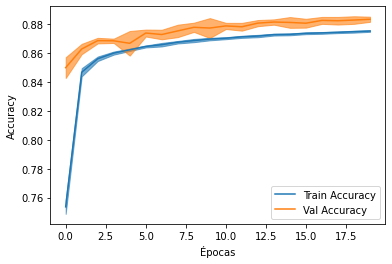

In [ ]:
plt.plot(train_acc_mean2, label = r'Train Accuracy', color = 'C0')
plt.fill_between(epochs, train_acc_mean2 - train_acc_std2, train_acc_mean2 + train_acc_std2, color = 'C0', alpha = 0.6)
plt.plot(val_acc_mean2, label = r'Val Accuracy', color = 'C1')
plt.fill_between(epochs, val_acc_mean2 - val_acc_std2, val_acc_mean2 + val_acc_std2, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Accuracy')
plt.legend()

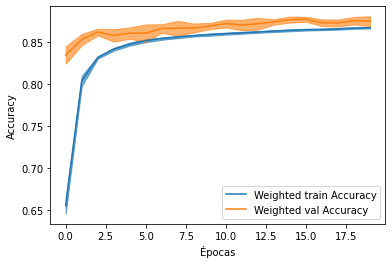

In [ ]:
plt.plot(train_acc_mean2w, label = r'Weighted train Accuracy', color = 'C0')
plt.fill_between(epochs, train_acc_mean2w - train_acc_std2w, train_acc_mean2w + train_acc_std2w, color = 'C0', alpha = 0.6)
plt.plot(val_acc_mean2w, label = r'Weighted val Accuracy', color = 'C1')
plt.fill_between(epochs, val_acc_mean2w - val_acc_std2w, val_acc_mean2w + val_acc_std2w, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Accuracy')
plt.legend()

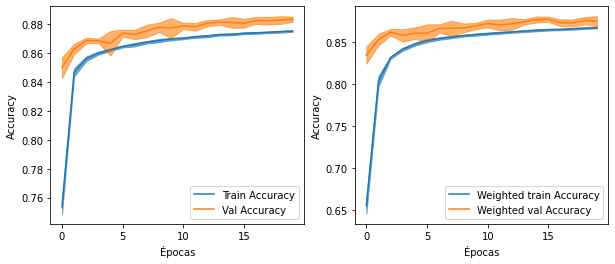

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(train_acc_mean2, label = r'Train Accuracy', color = 'C0')
ax1.fill_between(epochs, train_acc_mean2 - train_acc_std2, train_acc_mean2 + train_acc_std2, color = 'C0', alpha = 0.6)
ax1.plot(val_acc_mean2, label = r'Val Accuracy', color = 'C1')
ax1.fill_between(epochs, val_acc_mean2 - val_acc_std2, val_acc_mean2 + val_acc_std2, color = 'C1', alpha = 0.6)
ax1.set_xlabel(r'Épocas')
ax1.set_ylabel(r'Accuracy')
ax1.legend()

#plt.subplot(1,2,2)
ax2.plot(train_acc_mean2w, label = r'Weighted train Accuracy', color = 'C0')
ax2.fill_between(epochs, train_acc_mean2w - train_acc_std2w, train_acc_mean2w + train_acc_std2w, color = 'C0', alpha = 0.6)
ax2.plot(val_acc_mean2w, label = r'Weighted val Accuracy', color = 'C1')
ax2.fill_between(epochs, val_acc_mean2w - val_acc_std2w, val_acc_mean2w + val_acc_std2w, color = 'C1', alpha = 0.6)
ax2.set_xlabel(r'Épocas')
ax2.set_ylabel(r'Accuracy')
ax2.legend()

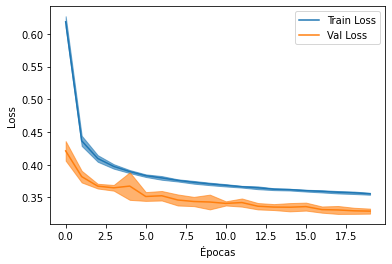

In [ ]:
plt.plot(train_loss_mean2, label = r'Train Loss', color = 'C0')
plt.fill_between(epochs, train_loss_mean2 - train_loss_std2, train_loss_mean2 + train_loss_std2, color = 'C0', alpha = 0.6)
plt.plot(val_loss_mean2, label = r'Val Loss', color = 'C1')
plt.fill_between(epochs, val_loss_mean2 - val_loss_std2, val_loss_mean2 + val_loss_std2, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Loss')
plt.legend()

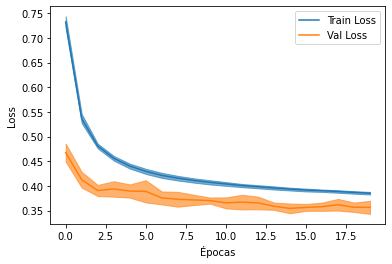

In [ ]:
plt.plot(train_loss_mean2w, label = r'Train Loss', color = 'C0')
plt.fill_between(epochs, train_loss_mean2w - train_loss_std2w, train_loss_mean2w + train_loss_std2w, color = 'C0', alpha = 0.6)
plt.plot(val_loss_mean2w, label = r'Val Loss', color = 'C1')
plt.fill_between(epochs, val_loss_mean2w - val_loss_std2w, val_loss_mean2w + val_loss_std2w, color = 'C1', alpha = 0.6)
plt.xlabel(r'Épocas')
plt.ylabel(r'Loss')
plt.legend()

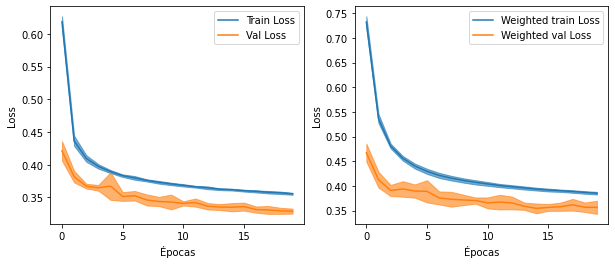

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(train_loss_mean2, label = r'Train Loss', color = 'C0')
ax1.fill_between(epochs, train_loss_mean2 - train_loss_std2, train_loss_mean2 + train_loss_std2, color = 'C0', alpha = 0.6)
ax1.plot(val_loss_mean2, label = r'Val Loss', color = 'C1')
ax1.fill_between(epochs, val_loss_mean2 - val_loss_std2, val_loss_mean2 + val_loss_std2, color = 'C1', alpha = 0.6)
ax1.set_xlabel(r'Épocas')
ax1.set_ylabel(r'Loss')
ax1.legend()

#--------------------------------------------------------------#

ax2.plot(train_loss_mean2w, label = r'Weighted train Loss', color = 'C0')
ax2.fill_between(epochs, train_loss_mean2w - train_loss_std2w, train_loss_mean2w + train_loss_std2w, color = 'C0', alpha = 0.6)
ax2.plot(val_loss_mean2w, label = r'Weighted val Loss', color = 'C1')
ax2.fill_between(epochs, val_loss_mean2w - val_loss_std2w, val_loss_mean2w + val_loss_std2w, color = 'C1', alpha = 0.6)
ax2.set_xlabel(r'Épocas')
ax2.set_ylabel(r'Loss')
ax2.legend()

In [ ]:
cmatrix2 = confusion_matrix(np.array(y_test2), np.argmax(test_pred2, axis = 1))
cmatrix2

array([[ 9517,   607,   743],
       [  271, 17768,   586],
       [  472,  1830,  5137]])

In [ ]:
cmatrix2w = confusion_matrix(np.array(y_test2w), np.argmax(test_pred2w, axis = 1))
cmatrix2w

array([[ 9378,   543,   946],
       [  227, 17050,  1348],
       [  326,  1116,  5997]])

In [ ]:
precisions2 = []
precisiong2 = []
precisionq2 = []

recalls2 = []
recallg2 = []
recallq2 = []

for i in range(10):
  precisions2.append(np.array(precision2)[i][0])
  precisiong2.append(np.array(precision2)[i][1])
  precisionq2.append(np.array(precision2)[i][2])
  recalls2.append(np.array(recall2)[i][0])
  recallg2.append(np.array(recall2)[i][1])
  recallq2.append(np.array(recall2)[i][2])

#----------------------------------------------------#

precisions2w = []
precisiong2w = []
precisionq2w = []

recalls2w = []
recallg2w = []
recallq2w = []

for i in range(10):
  precisions2w.append(np.array(precision2w)[i][0])
  precisiong2w.append(np.array(precision2w)[i][1])
  precisionq2w.append(np.array(precision2w)[i][2])
  recalls2w.append(np.array(recall2w)[i][0])
  recallg2w.append(np.array(recall2w)[i][1])
  recallq2w.append(np.array(recall2w)[i][2])

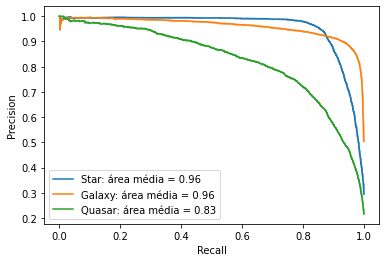

In [ ]:
plt.plot(np.average(np.vstack(recalls2), axis = 0),np.average(np.vstack(precisions2), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recalls2), axis = 0), np.average(np.vstack(precisions2), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(recallg2), axis = 0),np.average(np.vstack(precisiong2), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallg2), axis = 0), np.average(np.vstack(precisiong2), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(recallq2), axis = 0),np.average(np.vstack(precisionq2), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallq2), axis = 0), np.average(np.vstack(precisionq2), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(recalls2), axis = 0), np.std(np.vstack(precisions2), axis = 0) + np.average(np.vstack(precisions2), axis = 0), - np.std(np.vstack(precisions2), axis = 0) + np.average(np.vstack(precisions2), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallg2), axis = 0), np.std(np.vstack(precisiong2), axis = 0) + np.average(np.vstack(precisiong2), axis = 0), - np.std(np.vstack(precisiong2), axis = 0) + np.average(np.vstack(precisiong2), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallq2), axis = 0), np.std(np.vstack(precisionq2), axis = 0) + np.average(np.vstack(precisionq2), axis = 0), - np.std(np.vstack(precisionq2), axis = 0) + np.average(np.vstack(precisionq2), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'Recall')
plt.ylabel(r'Precision')
plt.legend()

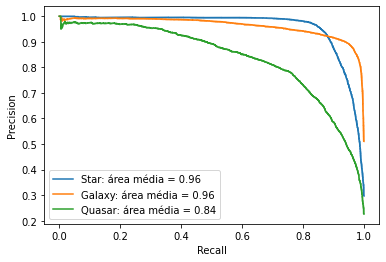

In [ ]:
plt.plot(np.average(np.vstack(recalls2w), axis = 0),np.average(np.vstack(precisions2w), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recalls2w), axis = 0), np.average(np.vstack(precisions2w), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(recallg2w), axis = 0),np.average(np.vstack(precisiong2w), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallg2w), axis = 0), np.average(np.vstack(precisiong2w), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(recallq2w), axis = 0),np.average(np.vstack(precisionq2w), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallq2w), axis = 0), np.average(np.vstack(precisionq2w), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(recalls2w), axis = 0), np.std(np.vstack(precisions2w), axis = 0) + np.average(np.vstack(precisions2w), axis = 0), - np.std(np.vstack(precisions2w), axis = 0) + np.average(np.vstack(precisions2w), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallg2w), axis = 0), np.std(np.vstack(precisiong2w), axis = 0) + np.average(np.vstack(precisiong2w), axis = 0), - np.std(np.vstack(precisiong2w), axis = 0) + np.average(np.vstack(precisiong2w), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(recallq2w), axis = 0), np.std(np.vstack(precisionq2w), axis = 0) + np.average(np.vstack(precisionq2w), axis = 0), - np.std(np.vstack(precisionq2w), axis = 0) + np.average(np.vstack(precisionq2w), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'Recall')
plt.ylabel(r'Precision')
plt.legend()

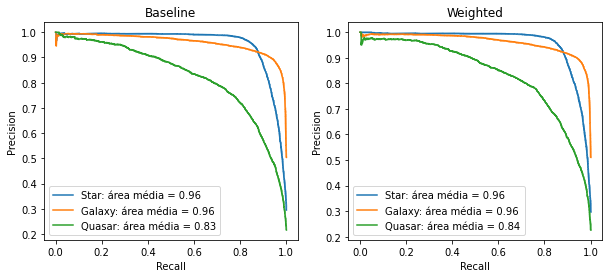

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(np.average(np.vstack(recalls2), axis = 0),np.average(np.vstack(precisions2), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recalls2), axis = 0), np.average(np.vstack(precisions2), axis = 0)), color = 'C0')
ax1.plot(np.average(np.vstack(recallg2), axis = 0),np.average(np.vstack(precisiong2), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallg2), axis = 0), np.average(np.vstack(precisiong2), axis = 0)), color = 'C1')
ax1.plot(np.average(np.vstack(recallq2), axis = 0),np.average(np.vstack(precisionq2), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallq2), axis = 0), np.average(np.vstack(precisionq2), axis = 0)), color = 'C2')
ax1.fill_between(np.average(np.vstack(recalls2), axis = 0), np.std(np.vstack(precisions2), axis = 0) + np.average(np.vstack(precisions2), axis = 0), - np.std(np.vstack(precisions2), axis = 0) + np.average(np.vstack(precisions2), axis = 0), color = 'C0', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(recallg2), axis = 0), np.std(np.vstack(precisiong2), axis = 0) + np.average(np.vstack(precisiong2), axis = 0), - np.std(np.vstack(precisiong2), axis = 0) + np.average(np.vstack(precisiong2), axis = 0), color = 'C1', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(recallq2), axis = 0), np.std(np.vstack(precisionq2), axis = 0) + np.average(np.vstack(precisionq2), axis = 0), - np.std(np.vstack(precisionq2), axis = 0) + np.average(np.vstack(precisionq2), axis = 0), color = 'C2', alpha = 0.5)

ax1.set_xlabel(r'Recall')
ax1.set_ylabel(r'Precision')
ax1.set_title(r'Baseline')
ax1.legend()

ax2.plot(np.average(np.vstack(recalls2w), axis = 0),np.average(np.vstack(precisions2w), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(recalls2w), axis = 0), np.average(np.vstack(precisions2w), axis = 0)), color = 'C0')
ax2.plot(np.average(np.vstack(recallg2w), axis = 0),np.average(np.vstack(precisiong2w), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(recallg2w), axis = 0), np.average(np.vstack(precisiong2w), axis = 0)), color = 'C1')
ax2.plot(np.average(np.vstack(recallq2w), axis = 0),np.average(np.vstack(precisionq2w), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(recallq2w), axis = 0), np.average(np.vstack(precisionq2w), axis = 0)), color = 'C2')
ax2.fill_between(np.average(np.vstack(recalls2w), axis = 0), np.std(np.vstack(precisions2w), axis = 0) + np.average(np.vstack(precisions2w), axis = 0), - np.std(np.vstack(precisions2w), axis = 0) + np.average(np.vstack(precisions2w), axis = 0), color = 'C0', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(recallg2w), axis = 0), np.std(np.vstack(precisiong2w), axis = 0) + np.average(np.vstack(precisiong2w), axis = 0), - np.std(np.vstack(precisiong2w), axis = 0) + np.average(np.vstack(precisiong2w), axis = 0), color = 'C1', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(recallq2w), axis = 0), np.std(np.vstack(precisionq2w), axis = 0) + np.average(np.vstack(precisionq2w), axis = 0), - np.std(np.vstack(precisionq2w), axis = 0) + np.average(np.vstack(precisionq2w), axis = 0), color = 'C2', alpha = 0.5)

ax2.set_xlabel(r'Recall')
ax2.set_ylabel(r'Precision')
ax2.set_title(r'Weighted')
ax2.legend()

In [ ]:
tprs2 = []
tprg2 = []
tprq2 = []

fprs2 = []
fprg2 = []
fprq2 = []

for i in range(10):
  tprs2.append(np.array(tpr2)[i][0])
  tprg2.append(np.array(tpr2)[i][1])
  tprq2.append(np.array(tpr2)[i][2])
  fprs2.append(np.array(fpr2)[i][0])
  fprg2.append(np.array(fpr2)[i][1])
  fprq2.append(np.array(fpr2)[i][2])

#-----------------------------------------------------------#

tprs2w = []
tprg2w = []
tprq2w = []

fprs2w = []
fprg2w = []
fprq2w = []

for i in range(10):
  tprs2w.append(np.array(tpr2w)[i][0])
  tprg2w.append(np.array(tpr2w)[i][1])
  tprq2w.append(np.array(tpr2w)[i][2])
  fprs2w.append(np.array(fpr2w)[i][0])
  fprg2w.append(np.array(fpr2w)[i][1])
  fprq2w.append(np.array(fpr2w)[i][2])

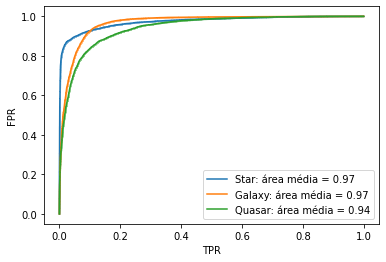

In [ ]:
plt.plot(np.average(np.vstack(fprs2), axis = 0),np.average(np.vstack(tprs2), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprs2), axis = 0), np.average(np.vstack(tprs2), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(fprg2), axis = 0),np.average(np.vstack(tprg2), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprg2), axis = 0), np.average(np.vstack(tprg2), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(fprq2), axis = 0),np.average(np.vstack(tprq2), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprq2), axis = 0), np.average(np.vstack(tprq2), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(fprs2), axis = 0), np.std(np.vstack(tprs2), axis = 0) + np.average(np.vstack(tprs2), axis = 0), - np.std(np.vstack(tprs2), axis = 0) + np.average(np.vstack(tprs2), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprg2), axis = 0), np.std(np.vstack(tprg2), axis = 0) + np.average(np.vstack(tprg2), axis = 0), - np.std(np.vstack(tprg2), axis = 0) + np.average(np.vstack(tprg2), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprq2), axis = 0), np.std(np.vstack(tprq2), axis = 0) + np.average(np.vstack(tprq2), axis = 0), - np.std(np.vstack(tprq2), axis = 0) + np.average(np.vstack(tprq2), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'TPR')
plt.ylabel(r'FPR')
plt.legend()

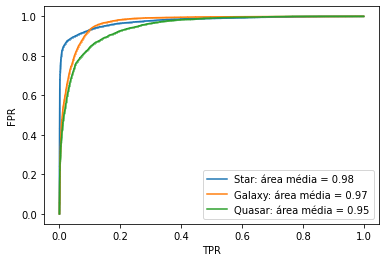

In [ ]:
plt.plot(np.average(np.vstack(fprs2w), axis = 0),np.average(np.vstack(tprs2w), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprs2w), axis = 0), np.average(np.vstack(tprs2w), axis = 0)), color = 'C0')
plt.plot(np.average(np.vstack(fprg2w), axis = 0),np.average(np.vstack(tprg2w), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprg2w), axis = 0), np.average(np.vstack(tprg2w), axis = 0)), color = 'C1')
plt.plot(np.average(np.vstack(fprq2w), axis = 0),np.average(np.vstack(tprq2w), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprq2w), axis = 0), np.average(np.vstack(tprq2w), axis = 0)), color = 'C2')
plt.fill_between(np.average(np.vstack(fprs2w), axis = 0), np.std(np.vstack(tprs2w), axis = 0) + np.average(np.vstack(tprs2w), axis = 0), - np.std(np.vstack(tprs2w), axis = 0) + np.average(np.vstack(tprs2w), axis = 0), color = 'C0', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprg2w), axis = 0), np.std(np.vstack(tprg2w), axis = 0) + np.average(np.vstack(tprg2w), axis = 0), - np.std(np.vstack(tprg2w), axis = 0) + np.average(np.vstack(tprg2w), axis = 0), color = 'C1', alpha = 0.5)
plt.fill_between(np.average(np.vstack(fprq2w), axis = 0), np.std(np.vstack(tprq2w), axis = 0) + np.average(np.vstack(tprq2w), axis = 0), - np.std(np.vstack(tprq2w), axis = 0) + np.average(np.vstack(tprq2w), axis = 0), color = 'C2', alpha = 0.5)

plt.xlabel(r'TPR')
plt.ylabel(r'FPR')
plt.legend()

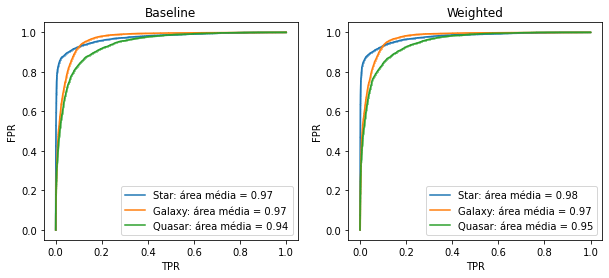

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(np.average(np.vstack(fprs2), axis = 0),np.average(np.vstack(tprs2), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprs2), axis = 0), np.average(np.vstack(tprs2), axis = 0)), color = 'C0')
ax1.plot(np.average(np.vstack(fprg2), axis = 0),np.average(np.vstack(tprg2), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprg2), axis = 0), np.average(np.vstack(tprg2), axis = 0)), color = 'C1')
ax1.plot(np.average(np.vstack(fprq2), axis = 0),np.average(np.vstack(tprq2), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprq2), axis = 0), np.average(np.vstack(tprq2), axis = 0)), color = 'C2')
ax1.fill_between(np.average(np.vstack(fprs2), axis = 0), np.std(np.vstack(tprs2), axis = 0) + np.average(np.vstack(tprs2), axis = 0), - np.std(np.vstack(tprs2), axis = 0) + np.average(np.vstack(tprs2), axis = 0), color = 'C0', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(fprg2), axis = 0), np.std(np.vstack(tprg2), axis = 0) + np.average(np.vstack(tprg2), axis = 0), - np.std(np.vstack(tprg2), axis = 0) + np.average(np.vstack(tprg2), axis = 0), color = 'C1', alpha = 0.5)
ax1.fill_between(np.average(np.vstack(fprq2), axis = 0), np.std(np.vstack(tprq2), axis = 0) + np.average(np.vstack(tprq2), axis = 0), - np.std(np.vstack(tprq2), axis = 0) + np.average(np.vstack(tprq2), axis = 0), color = 'C2', alpha = 0.5)

ax1.set_xlabel(r'TPR')
ax1.set_ylabel(r'FPR')
ax1.set_title(r'Baseline')
ax1.legend()

ax2.plot(np.average(np.vstack(fprs2w), axis = 0),np.average(np.vstack(tprs2w), axis = 0), label = r'Star: área média = %.2f'%auc(np.average(np.vstack(fprs2w), axis = 0), np.average(np.vstack(tprs2w), axis = 0)), color = 'C0')
ax2.plot(np.average(np.vstack(fprg2w), axis = 0),np.average(np.vstack(tprg2w), axis = 0), label = r'Galaxy: área média = %.2f'%auc(np.average(np.vstack(fprg2w), axis = 0), np.average(np.vstack(tprg2w), axis = 0)), color = 'C1')
ax2.plot(np.average(np.vstack(fprq2w), axis = 0),np.average(np.vstack(tprq2w), axis = 0), label = r'Quasar: área média = %.2f'%auc(np.average(np.vstack(fprq2w), axis = 0), np.average(np.vstack(tprq2w), axis = 0)), color = 'C2')
ax2.fill_between(np.average(np.vstack(fprs2w), axis = 0), np.std(np.vstack(tprs2w), axis = 0) + np.average(np.vstack(tprs2w), axis = 0), - np.std(np.vstack(tprs2w), axis = 0) + np.average(np.vstack(tprs2w), axis = 0), color = 'C0', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(fprg2w), axis = 0), np.std(np.vstack(tprg2w), axis = 0) + np.average(np.vstack(tprg2w), axis = 0), - np.std(np.vstack(tprg2w), axis = 0) + np.average(np.vstack(tprg2w), axis = 0), color = 'C1', alpha = 0.5)
ax2.fill_between(np.average(np.vstack(fprq2w), axis = 0), np.std(np.vstack(tprq2w), axis = 0) + np.average(np.vstack(tprq2w), axis = 0), - np.std(np.vstack(tprq2w), axis = 0) + np.average(np.vstack(tprq2w), axis = 0), color = 'C2', alpha = 0.5)

ax2.set_xlabel(r'TPR')
ax2.set_ylabel(r'FPR')
ax2.set_title(r'Weighted')
ax2.legend()



---

Importancia das features para o modelo baseline



---



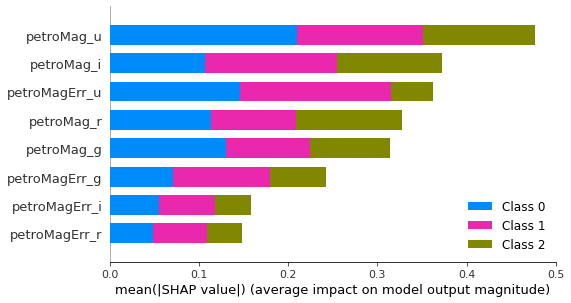

In [ ]:
e2 = shap.DeepExplainer(model2, np.array(x_train2)[:5000,:])
shap_values2 = e2.shap_values(np.array(x_train2)[:2500,:])
shap.summary_plot(shap_values2, np.array(x_test2)[:1000,:], feature_names = x_test2.columns)



---
Importancia das features para o modelo com pesos


---


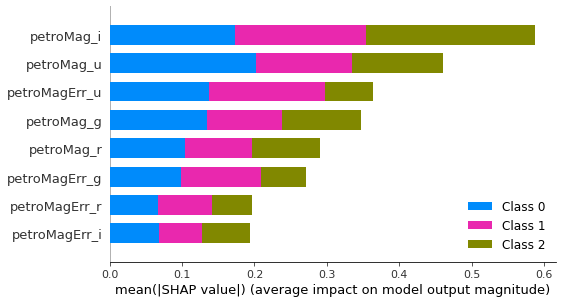

In [ ]:
e2w = shap.DeepExplainer(model2w, np.array(x_train2)[:5000,:])
shap_values2w = e2w.shap_values(np.array(x_train2w)[:2500,:])
shap.summary_plot(shap_values2w, np.array(x_test2w)[:1000,:], feature_names = x_test2.columns)

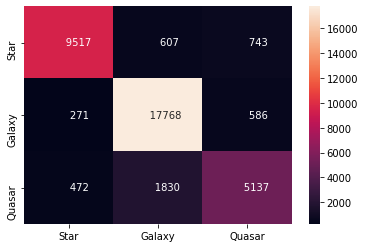

In [ ]:
sns.heatmap(cmatrix2, xticklabels = labels, yticklabels = labels, annot = True, fmt = '10')

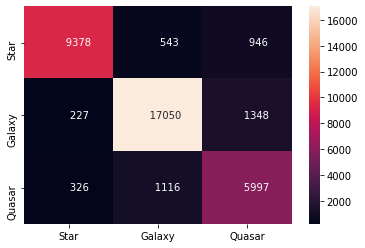

In [ ]:
sns.heatmap(cmatrix2w, xticklabels = labels, yticklabels = labels, annot = True, fmt = '10')

Text(0.5, 1.0, 'Weighted')

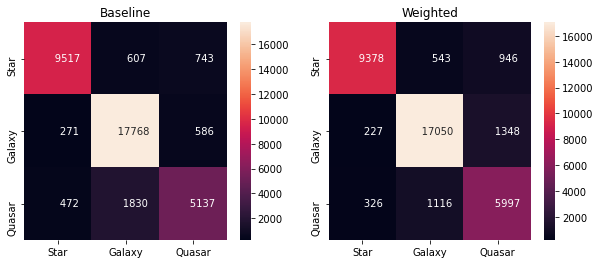

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

sns.heatmap(cmatrix2, xticklabels = labels, yticklabels = labels, annot = True, fmt = '10', ax = ax1)
ax1.set_title(r'Baseline')
sns.heatmap(cmatrix2w, xticklabels = labels, yticklabels = labels, annot = True, fmt = '10', ax = ax2)
ax2.set_title(r'Weighted')

In [ ]:
y_test2.value_counts()

1    18625
0    10867
2     7439
Name: class, dtype: int64

In [ ]:
report2 = classification_report(y_test2, np.argmax(test_pred2, axis = 1), target_names = ['Star', 'Galaxy', 'QSO'], output_dict = True)
report2 = pd.DataFrame(report2)
report2.drop(index = ['support'], columns = ['accuracy', 'macro avg', 'weighted avg'], inplace = True)
report2

,Star,Galaxy,QSO
precision,0.927583,0.879386,0.794463
recall,0.875771,0.953987,0.690550
f1-score,0.900932,0.915169,0.738871


In [ ]:
report2w = classification_report(y_test2w, np.argmax(test_pred2w, axis = 1), target_names = ['Star', 'Galaxy', 'QSO'], output_dict = True)
report2w = pd.DataFrame(report2w)
report2w.drop(index = ['support'], columns = ['accuracy', 'macro avg', 'weighted avg'], inplace = True)
report2w

,Star,Galaxy,QSO
precision,0.944316,0.911326,0.723314
recall,0.862980,0.915436,0.806157
f1-score,0.901817,0.913377,0.762492
